#### Dans cette verion nous allons essayé de nombreuses versions pour affiner ce qu'il sera intéressant de proposer comme résultat
Le challenge porte sur le f1_score

# Import libraries

In [9]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt


# Read file with labels

In [10]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


J'ai essayé de nombreuses possibilités :
 - new_user en catégoriel ou en numérique
 - avec les différentes features par 1/2/3/4 et 5 toutes les possibilités
 - stratify country + source mais également que country, que source 

Pour chaue possibilité je boucle sur 20 itérations et pour chacune, je récupère les résultats du f1_score train et test
Cela me permet de vérifier un résultat plus cohérent et me permet de voir s'il existe des variations importantes selon le random_state
Je propose ensuite le fichier csv correspondant à la meilleure stabilité entre train et test et avec la variance la plus faible

In [11]:
features_list = ['country','new_user','age','total_pages_visited','source']
numerical_columns = ['age','total_pages_visited']
categorical_columns = ['country','source','new_user']
target_variable = 'converted'

X = data[features_list]
Y = data[target_variable]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [12]:
scores_df = pd.DataFrame(columns = ['model', 'f1_score_train', 'f1_score_test'])

for i in range (20):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i**3,stratify=Y)

    X_train = preprocessor.fit_transform(X_train)

    X_test = preprocessor.transform(X_test)

    classifier = LogisticRegression(class_weight={0:1,1:1.59}) # 

    classifier.fit(X_train, Y_train)

    coefficients = classifier.coef_[0]
    intercept = classifier.intercept_[0]
    feature_names = numerical_columns + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_columns))
    # Associer les coefficients aux noms des caractéristiques
    feature_coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)

    new_rows = [
        {'model': 'LogisticRegression', 'f1_score_train':f1_score(Y_train, Y_train_pred), 'f1_score_test':f1_score(Y_test, Y_test_pred)}
    ]

    scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)



C:\Users\franc\AppData\Local\Temp\ipykernel_19764\899984516.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)


In [13]:
scores_df.describe(include='all')

,model,f1_score_train,f1_score_test
count,20,20.000000,20.000000
unique,1,NaN,NaN
top,LogisticRegression,NaN,NaN
freq,20,NaN,NaN
mean,NaN,0.770580,0.767124
std,NaN,0.001377,0.005998
min,NaN,0.768313,0.752487
25%,NaN,0.769495,0.763879
50%,NaN,0.770642,0.767699
75%,NaN,0.771665,0.769948


In [14]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))

print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))

Confusion matrix on train set : 
[[218963   1357]
 [  1878   5466]]
Confusion matrix on test set : 
[[54769   311]
 [  507  1329]]


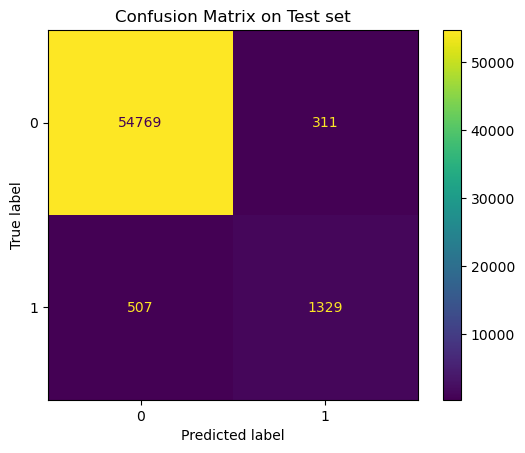

In [15]:
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

La matrice de confusion permet également de voir si la feature permet mieux d'identifier les prédictions positives ou négatives.